In [120]:
"""Deterministic co-optimization of pumped hydro and wind generation.

This module implements the deterministic linear program described by
Vespucci et al. (2012), "A stochastic model for the daily coordination of pumped
storage hydro plants and wind power plants". The implementation follows the
notation used in Section 2 of the paper and mirrors the deterministic case
presented before the stochastic extension.

The model is solved with SciPy's ``linprog`` (HiGHS backend). The code is
self-contained so it can be run without a commercial solver.
"""

import pyomo.environ as pyo
import matplotlib.pyplot as plt

# Create the model
model = pyo.ConcreteModel()

# Map sets to model with doc argument
model.T = pyo.Set(initialize=list(range(1, 25)) , ordered=True, doc="Time periods 1-24")
model.J = pyo.Set(initialize=["v1", "v2"], doc="Reservoir nodes")
model.I = pyo.Set(initialize=["c_1_2", "c_2_1"], doc="Inter-reservoir water flows")
model.K = pyo.Set(initialize=["k_building"], doc="Water demand flows")
model.L = pyo.Set(initialize=["l_WWT"], doc="Water supply flows")
model.N = pyo.Set(initialize=["n_SP", "n_WP"], doc="Energy supply flows")
model.M = pyo.Set(initialize=["m_demand", "m_treatment", "m_distribution"], doc="Energy demand flows")

# Parameters
model.A = pyo.Param(
    model.I, model.J,
    initialize={
        ("c_1_2", "v1"): -1, ("c_1_2", "v2"): 1,
        ("c_2_1", "v1"):  1, ("c_2_1", "v2"): -1
    },
    default=0, doc="Inter-reservoir flow incidence matrix (positive into reservoir, negative out)."
)
model.k = pyo.Param(
    model.I, 
    initialize={"c_1_2": 1.0, "c_2_1": -1.7}, 
    default=0, doc="Power generation coefficients for inter-reservoir flows (sign indicates turbine(+)/pump(-))."
)
model.q_max_i = pyo.Param(
    model.I, 
    initialize={"c_1_2": 100, "c_2_1": 50}, 
    default=0, doc="Maximum flow limits for inter-reservoir connections (q_i,t ≤ q_max_i) [m^3/h]."
)
model.q_max_k = pyo.Param(
    model.K, 
    initialize={"k_building": 200}, 
    default=0, doc="Maximum demand-side water flows (q_k,t ≤ q_max_k) [m^3/h]."
)
model.q_max_l = pyo.Param(
    model.L, 
    initialize={"l_WWT": 1000}, 
    default=0, doc="Maximum supply-side water inflows (q_l,t ≤ q_max_l) [m^3/h]."
)
model.e_max_m = pyo.Param(
    model.M, 
    initialize={"m_demand": 300, "m_treatment": 200, "m_distribution": 300}, 
    default=0,
    doc="Maximum energy outflows to demand sinks (h_m,t ≤ e_max_m) [MWh]."
)
model.e_max_n = pyo.Param(
    model.N, 
    initialize={"n_SP": 500, "n_WP": 400}, 
    default=0, doc="Maximum energy inflows from supply sources (h_n,t ≤ e_max_n) [MWh]."
)
model.v_init = pyo.Param(
    model.J, 
    initialize={"v1": 50, "v2": 50}, 
    default=0, doc="Initial reservoir volumes v_{j,0} [m^3]."
)
model.v_max = pyo.Param(
    model.J, 
    initialize={"v1": 100, "v2": 100}, 
    default=0, doc="Upper bounds on reservoir volumes (0 ≤ v_{j,t} ≤ v_max_j) [m^3]."
)
model.v_min = pyo.Param(
    model.J, 
    initialize={"v1": 50, "v2": 50}, 
    default=0, doc="Required terminal reservoir volumes v_{j,T} ≥ v_min_j [m^3]."
)
model.demand_house = pyo.Param(
    model.T, 
    initialize={t: 50 if t <= 6 or t >= 19 else 200 for t in model.T}, 
    default=0, doc="Household water demand trajectory over time [m^3/h]."
)
model.e_house = pyo.Param(
    model.T, 
    initialize={t: 30 if t <= 6 or t >= 19 else 60 for t in model.T}, 
    default=0, doc="Household electric demand trajectory over time [MWh]."
)
model.wastewater_house = pyo.Param(
    model.T, 
    initialize={t: 0 if t <= 4 else 40 for t in model.T}, 
    default=0, doc="Household wastewater production over time [m^3/h]."
)
model.rainfall_collection = pyo.Param(
    model.T, 
    initialize={t: 0 if t <= 4 or t >= 7 else 80 for t in model.T}, 
    default=0, doc="Rainwater harvesting inflow over time [m^3/h]."
)
model.solar_house = pyo.Param(
    model.T, 
    initialize={t: 0 if t <= 6 or t >= 19 else 80 for t in model.T}, 
    default=0, doc="Solar PV generation available over time [MWh]."
)
model.turbine = pyo.Param(
    model.T, 
    initialize={t: 50 for t in model.T}, 
    default=0, doc="Turbine-related energy contribution term (e.g., max available/coeff) over time."
)
model.e_treatment = pyo.Param(
    model.T, 
    initialize={t: 25 for t in model.T}, 
    default=0, doc="Electricity required for water/wastewater treatment over time [MWh]."
)
model.e_distribution = pyo.Param(
    model.T, 
    initialize={t: 15 for t in model.T}, 
    default=0, doc="Electricity required for water distribution over time [MWh]."
)
model.lambda_t = pyo.Param(
    model.T, 
    initialize={t: 1 for t in model.T}, 
    default=0, doc="Unit selling price for water/energy at time t."
)
model.mu_t = pyo.Param(
    model.T, 
    initialize={t: 3 for t in model.T}, 
    default=0, doc="Unit buying price for water/energy at time t."
)

# Variables
model.q_i = pyo.Var(model.I, model.T, domain=pyo.NonNegativeReals)  # Inter-reservoir flows
model.q_k = pyo.Var(model.K, model.T, domain=pyo.NonNegativeReals)  # Supply flows
model.q_l = pyo.Var(model.L, model.T, domain=pyo.NonNegativeReals)  # Demand flows
model.e_m = pyo.Var(model.M, model.T, domain=pyo.NonNegativeReals)  # Supply currents
model.e_n = pyo.Var(model.N, model.T, domain=pyo.NonNegativeReals)  # Demand currents
model.v = pyo.Var(model.J, model.T, domain=pyo.NonNegativeReals)    # Reservoir volumes
model.W_sell = pyo.Var(model.T, domain=pyo.NonNegativeReals)        # Water sold
model.W_buy = pyo.Var(model.T, domain=pyo.NonNegativeReals)         # Water bought
model.E_sell = pyo.Var(model.T, domain=pyo.NonNegativeReals)        # Energy sold
model.E_buy = pyo.Var(model.T, domain=pyo.NonNegativeReals)         # Energy bought

# Constraints

# Flow limits (Constraint 2)
def flow_limit_i_rule(model, i, t):
    return model.q_i[i, t] <= model.q_max_i[i]
model.flow_limit_i = pyo.Constraint(model.I, model.T, rule=flow_limit_i_rule)

def flow_limit_s_rule(model, k, t):
    return model.q_k[k, t] <= model.q_max_k[k]
model.flow_limit_k = pyo.Constraint(model.K, model.T, rule=flow_limit_s_rule)

def flow_limit_d_rule(model, l, t):
    return model.q_l[l, t] <= model.q_max_l[l]
model.flow_limit_l = pyo.Constraint(model.L, model.T, rule=flow_limit_d_rule)

def current_limit_k_rule(model, m, t):
    return model.e_m[m, t] <= model.e_max_m[m]
model.current_limit_m = pyo.Constraint(model.M, model.T, rule=current_limit_k_rule)

def current_limit_p_rule(model, n, t):
    return model.e_n[n, t] <= model.e_max_n[n]
model.current_limit_n = pyo.Constraint(model.N, model.T, rule=current_limit_p_rule)

# Storage limits (Constraint 3)
def storage_limit_rule(model, j, t):
    return model.v[j, t] <= model.v_max[j]
model.storage_limit = pyo.Constraint(model.J, model.T, rule=storage_limit_rule)

# Final storage minimum (Constraint 4)
def final_storage_rule(model, j):
    return model.v[j, max(model.T)] >= model.v_min[j]
model.final_storage = pyo.Constraint(model.J, rule=final_storage_rule)

# Reservoir balance (Constraint 5)
def reservoir_balance_rule(model, j, t):
    # Get previous volume
    if t == min(model.T):
        previous_v = model.v_init[j]
    else:
        t_list = list(model.T)
        t_idx = t_list.index(t)
        previous_t = t_list[t_idx - 1]
        previous_v = model.v[j, previous_t]
    
    supply_flows = sum(model.q_k[k, t] for k in model.K)
    demand_flows = sum(model.q_l[l, t] for l in model.L)
    inter_flows = sum(model.A[i, j] * model.q_i[i, t] for i in model.I)
    
    return model.v[j, t] == previous_v + supply_flows - demand_flows + inter_flows

model.reservoir_balance = pyo.Constraint(model.J, model.T, rule=reservoir_balance_rule)

# Water demand balance (Constraint 6)
def water_demand_balance_rule(model, t):
    return sum(model.q_k[k, t] for k in model.K) == model.demand_house[t] + model.W_sell[t]
model.water_demand_balance = pyo.Constraint(model.T, rule=water_demand_balance_rule)

# Water supply balance (Constraint 7)
def water_supply_balance_rule(model, t):
    return (sum(model.q_l[l, t] for l in model.L) == 
            model.wastewater_house[t] + model.rainfall_collection[t] + model.W_buy[t])
model.water_supply_balance = pyo.Constraint(model.T, rule=water_supply_balance_rule)

# Electrical balance (Constraint 8)
def electrical_balance_rule(model, t):
    return sum(model.e_n[n, t] for n in model.N) == sum(model.e_m[m, t] for m in model.M)
model.electrical_balance = pyo.Constraint(model.T, rule=electrical_balance_rule)

# Electrical supply balance (Constraint 9)
def electrical_supply_balance_rule(model, t):
    # Power from positive k_i flows (turbines)
    turbine_power = sum(abs(model.k[i]) * model.q_i[i, t] for i in model.I if pyo.value(model.k[i]) > 0)
    
    return (sum(model.e_n[n, t] for n in model.N) == 
            model.solar_house[t] + model.turbine[t] + turbine_power + model.E_buy[t])
model.electrical_supply_balance = pyo.Constraint(model.T, rule=electrical_supply_balance_rule)

# Electrical demand balance (Constraint 10)
def electrical_demand_balance_rule(model, t):
    return (sum(model.e_m[m, t] for m in model.M) == 
            model.e_house[t] + model.e_treatment[t] + model.e_distribution[t] + model.E_sell[t])
model.electrical_demand_balance = pyo.Constraint(model.T, rule=electrical_demand_balance_rule)

# Objective function (Equation 1)
def objective_rule(model):
    return sum(model.lambda_t[t] * (model.W_sell[t] + model.E_sell[t]) - 
               model.mu_t[t] * (model.W_buy[t] + model.E_buy[t]) for t in model.T)
model.objective = pyo.Objective(rule=objective_rule, sense=pyo.maximize)

# Solve the model
solver = pyo.SolverFactory('gurobi')  # You can change this to 'gurobi' if you have Gurobi license
results = solver.solve(model, tee=True)

Read LP format model from file /var/folders/3w/hd5h2k7x1vj43929dpnp39p40000gn/T/tmpz76z7c8m.pyomo.lp
Reading time = 0.00 seconds
x1: 434 rows, 360 columns, 960 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 25.0.0 25A354)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 434 rows, 360 columns and 960 nonzeros
Model fingerprint: 0x8fb47c57
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 1e+03]
Presolve removed 386 rows and 227 columns
Presolve time: 0.00s
Presolved: 48 rows, 133 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0260000e+04   3.862500e+03   0.000000e+00      0s
      56   -4.7300000e+03   0.000000e+00   0.000000e+00      0s

Solved in 56 iterations and 0.00 seconds (0.00 work units)
Optimal objective -4.7300000

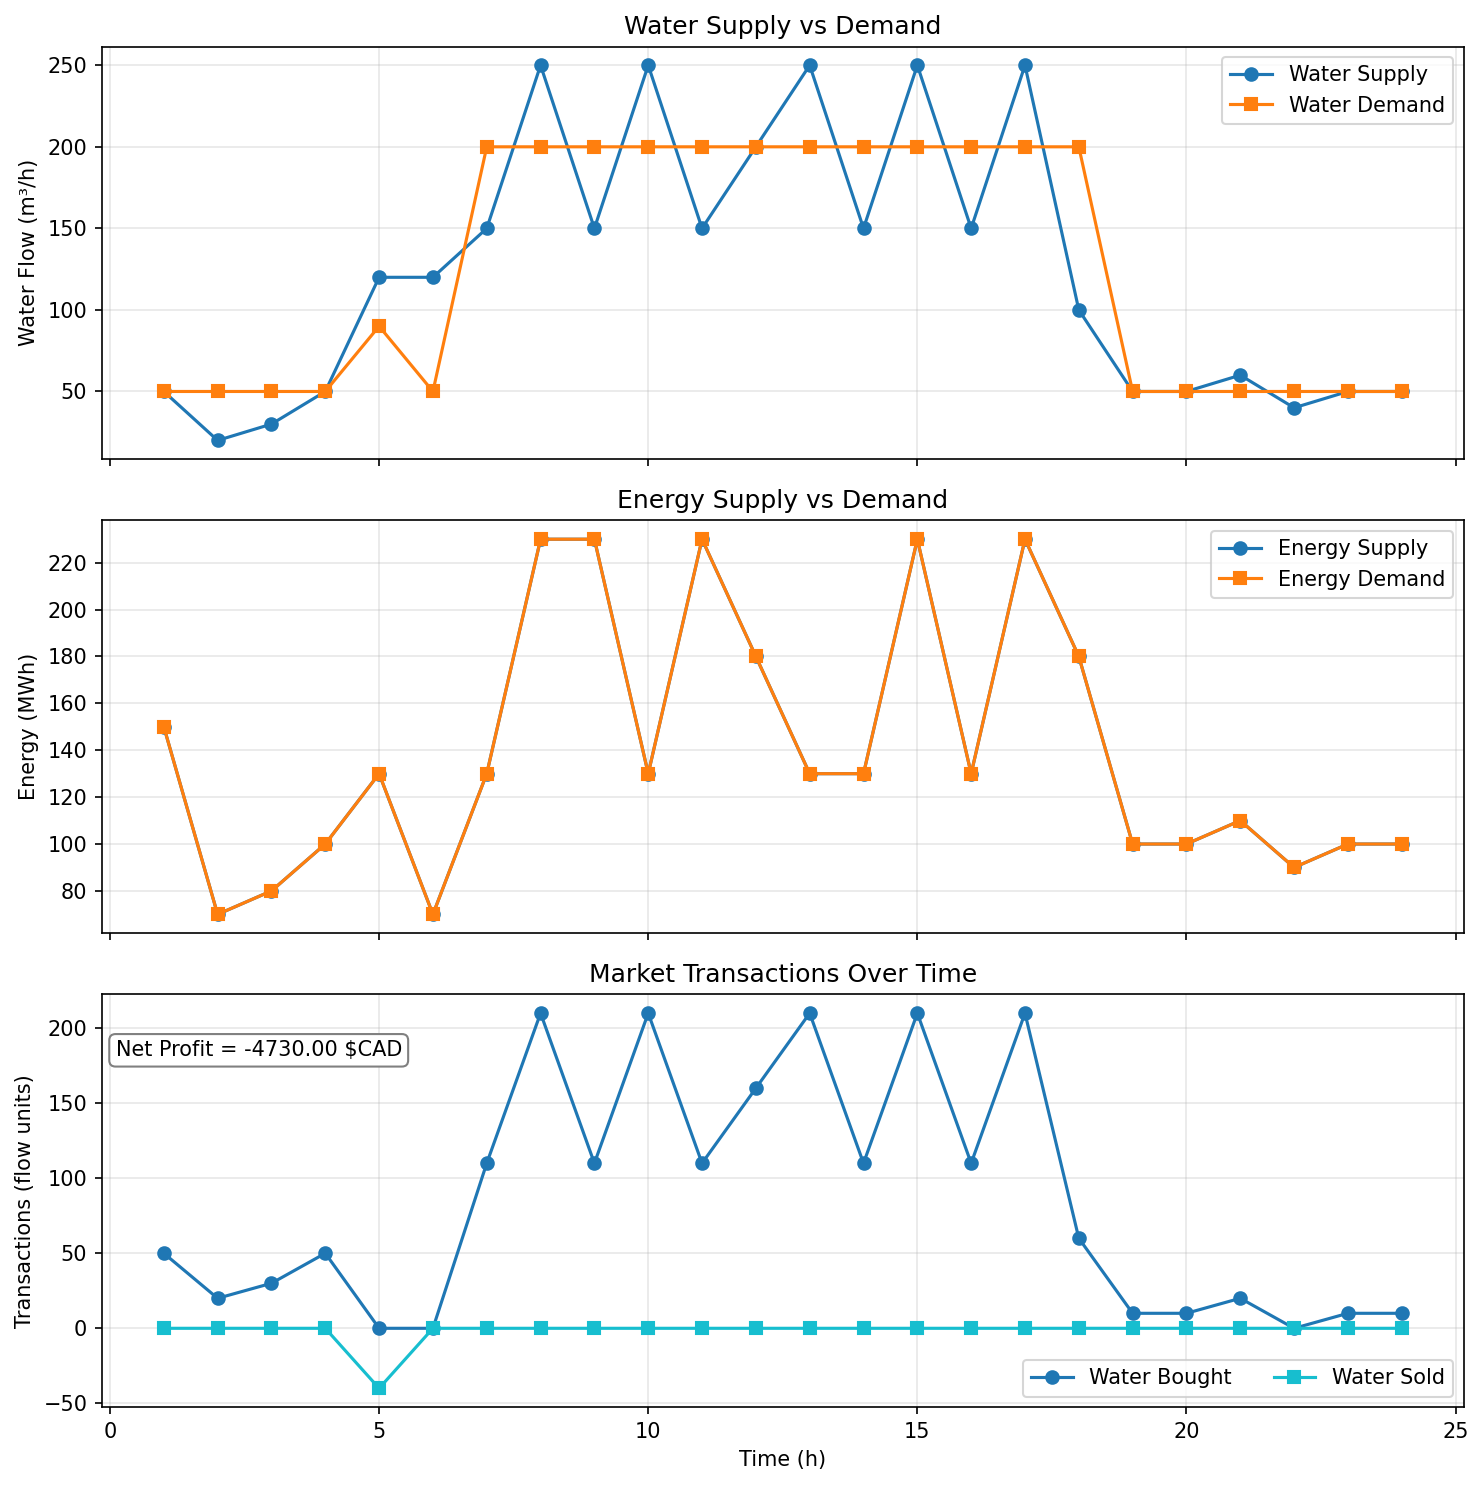

In [119]:
# Visualise supply-demand balances and market transactions
time_points = list(model.T)

water_supply = [sum(pyo.value(model.q_l[l, t]) for l in model.L) for t in time_points]
water_demand = [sum(pyo.value(model.q_k[k, t]) for k in model.K) for t in time_points]

energy_supply = [sum(pyo.value(model.e_n[n, t]) for n in model.N) for t in time_points]
energy_demand = [sum(pyo.value(model.e_m[m, t]) for m in model.M) for t in time_points]

water_bought = [pyo.value(model.W_buy[t]) for t in time_points]
water_sold = [pyo.value(model.W_sell[t]) for t in time_points]
energy_bought = [pyo.value(model.E_buy[t]) for t in time_points]
energy_sold = [pyo.value(model.E_sell[t]) for t in time_points]
net_profit = pyo.value(model.objective)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=True, dpi=150)

axes[0].plot(time_points, water_supply, marker='o', label='Water Supply')
axes[0].plot(time_points, water_demand, marker='s', label='Water Demand')
axes[0].set_ylabel('Water Flow (m³/h)')
axes[0].set_title('Water Supply vs Demand')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(time_points, energy_supply, marker='o', label='Energy Supply')
axes[1].plot(time_points, energy_demand, marker='s', label='Energy Demand')
axes[1].set_ylabel('Energy (MWh)')
axes[1].set_title('Energy Supply vs Demand')
axes[1].legend()
axes[1].grid(alpha=0.3)

axes[2].plot(time_points, water_bought, marker='o', label='Water Bought', color='tab:blue')
axes[2].plot(time_points, [-val for val in water_sold], marker='s', label='Water Sold', color='tab:cyan')
# axes[2].plot(time_points, energy_bought, marker='o', label='Energy Bought', color='tab:red')
# axes[2].plot(time_points, [-val for val in energy_sold], marker='s', label='Energy Sold', color='tab:orange')
axes[2].set_ylabel('Transactions (flow units)')
axes[2].set_xlabel('Time (h)')
axes[2].set_title('Market Transactions Over Time')
axes[2].legend(ncol=2)
axes[2].grid(alpha=0.3)
axes[2].annotate(
    f'Net Profit = {net_profit:.2f} $CAD',
    xy=(0.01, 0.85),
    xycoords='axes fraction',
    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.5')
)

plt.tight_layout()
plt.show()


Optimal solution found!
Objective value: 1320.00

=== SOLUTION SUMMARY ===

Reservoir Volumes (final):
v[v1, 24] = 8000.00
v[v2, 24] = 8000.00

Total Water Transactions:
Total Water Bought: 0.00
Total Water Sold: 0.00

Total Energy Transactions:
Total Energy Bought: 0.00
Total Energy Sold: 1320.00


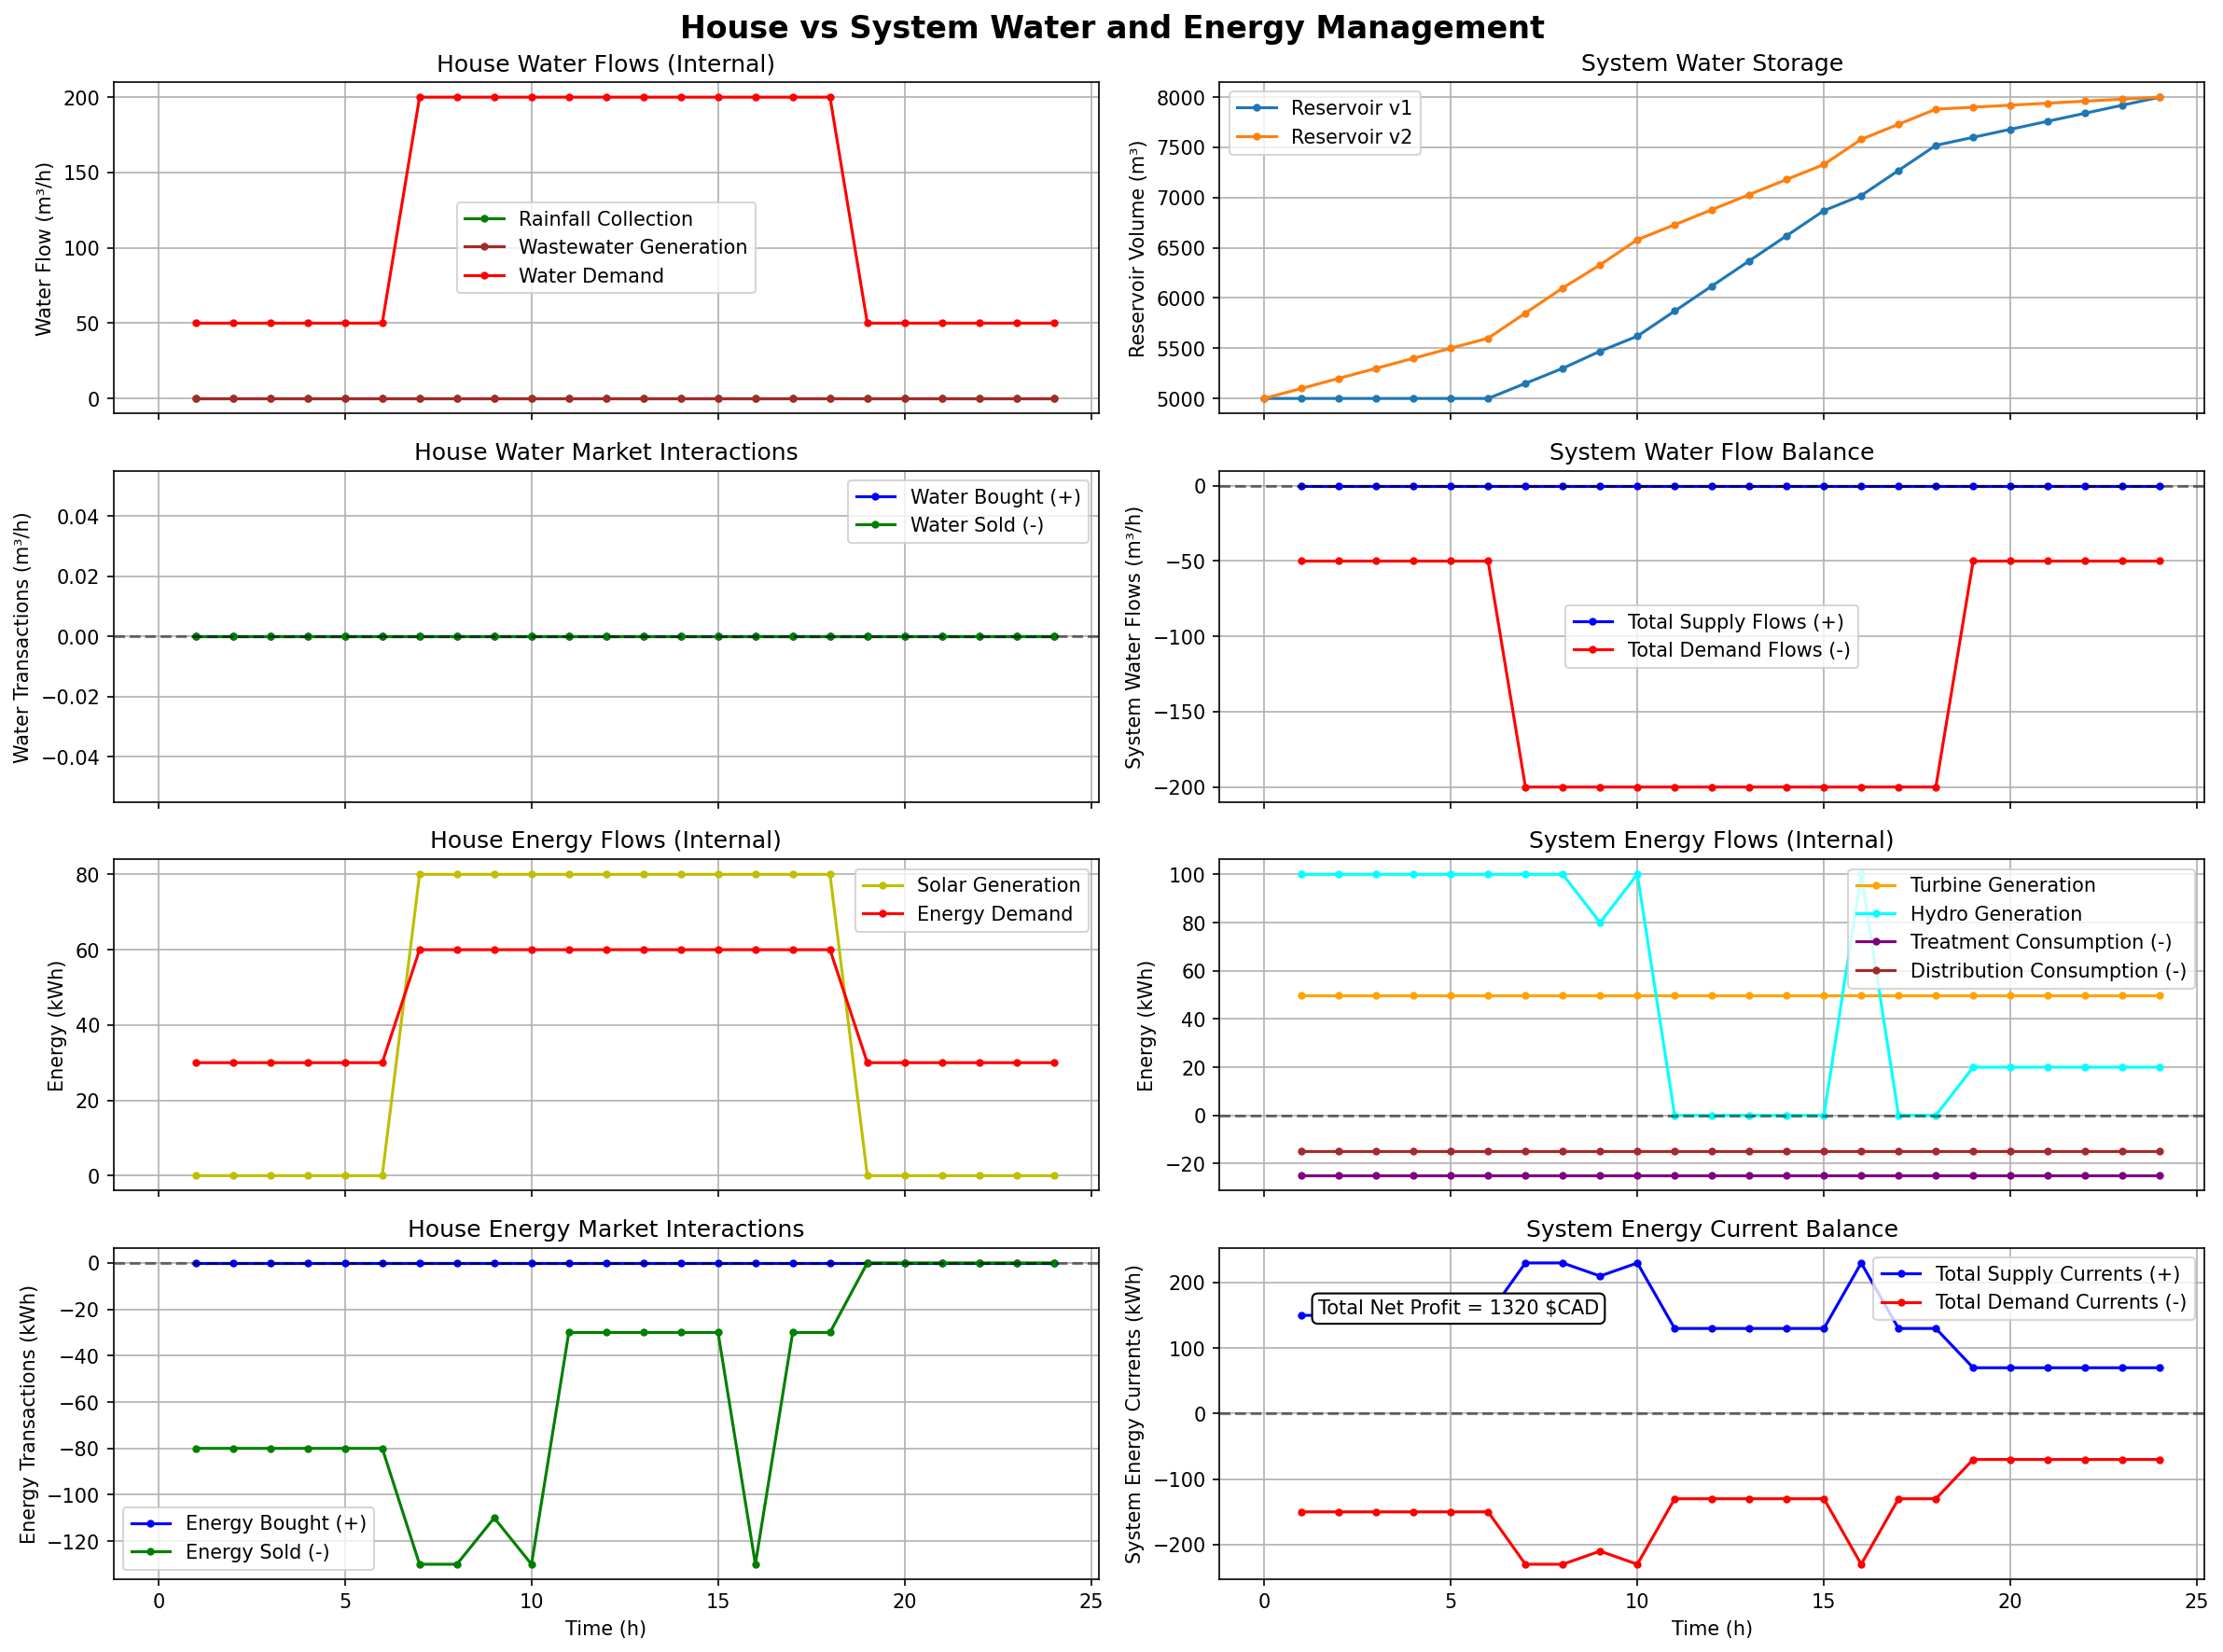

In [111]:
# Check solver status
if results.solver.termination_condition == pyo.TerminationCondition.optimal:
    print("Optimal solution found!")
    print(f"Objective value: {pyo.value(model.objective):.2f}")
    
    # Print solution summary
    print("\n=== SOLUTION SUMMARY ===")
    
    print("\nReservoir Volumes (final):")
    for j in model.J:
        final_t = max(model.T)
        print(f"v[{j}, {final_t}] = {pyo.value(model.v[j, final_t]):.2f}")
    
    print("\nTotal Water Transactions:")
    total_w_buy = sum(pyo.value(model.W_buy[t]) for t in model.T)
    total_w_sell = sum(pyo.value(model.W_sell[t]) for t in model.T)
    print(f"Total Water Bought: {total_w_buy:.2f}")
    print(f"Total Water Sold: {total_w_sell:.2f}")
    
    print("\nTotal Energy Transactions:")
    total_e_buy = sum(pyo.value(model.E_buy[t]) for t in model.T)
    total_e_sell = sum(pyo.value(model.E_sell[t]) for t in model.T)
    print(f"Total Energy Bought: {total_e_buy:.2f}")
    print(f"Total Energy Sold: {total_e_sell:.2f}")
    
    # Create visualization with side-by-side layout
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 12), sharex=True, dpi=150)
    fig.suptitle('House vs System Water and Energy Management', fontsize=16, fontweight='bold')
    
    # Row 1: Water flows within house vs system
    # House water flows (internal)
    axs[0, 0].plot(model.T, [pyo.value(model.rainfall_collection[t]) for t in model.T], "-g.", label="Rainfall Collection")
    axs[0, 0].plot(model.T, [pyo.value(model.wastewater_house[t]) for t in model.T], ".-", color="brown", label="Wastewater Generation")
    axs[0, 0].plot(model.T, [pyo.value(model.demand_house[t]) for t in model.T], "-r.", label="Water Demand")
    axs[0, 0].set_ylabel('Water Flow (m³/h)')
    axs[0, 0].legend()
    axs[0, 0].grid()
    axs[0, 0].set_title("House Water Flows (Internal)")
    
    # System water flows (internal - reservoir levels)
    for j in model.J:
        v_values = [pyo.value(model.v_init[j])] + [pyo.value(model.v[j, t]) for t in model.T]
        axs[0, 1].plot(range(0, len(model.T)+1), v_values, ".-", label=f"Reservoir {j}")
    axs[0, 1].set_ylabel('Reservoir Volume (m³)')
    axs[0, 1].legend()
    axs[0, 1].grid()
    axs[0, 1].set_title("System Water Storage")
    
    # Row 2: Water market interactions
    # House water market interactions
    house_w_net_buy = [pyo.value(model.W_buy[t]) for t in model.T]
    house_w_net_sell = [-pyo.value(model.W_sell[t]) for t in model.T]  # Negative for selling (outflow)
    
    axs[1, 0].plot(model.T, house_w_net_buy, "-b.", label="Water Bought (+)")
    axs[1, 0].plot(model.T, house_w_net_sell, "-g.", label="Water Sold (-)")
    axs[1, 0].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    axs[1, 0].set_ylabel('Water Transactions (m³/h)')
    axs[1, 0].legend()
    axs[1, 0].grid()
    axs[1, 0].set_title("House Water Market Interactions")
    
    # System water flows (supply and demand flows)
    total_supply = [sum(pyo.value(model.q_l[l, t]) for l in model.L) for t in model.T]  # model.S not defined, so skip this line or define S if needed
    total_demand = [-sum(pyo.value(model.q_k[k, t]) for k in model.K) for t in model.T]  # Negative for demand
    
    axs[1, 1].plot(model.T, total_supply, "-b.", label="Total Supply Flows (+)")
    axs[1, 1].plot(model.T, total_demand, "-r.", label="Total Demand Flows (-)")
    axs[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    axs[1, 1].set_ylabel('System Water Flows (m³/h)')
    axs[1, 1].legend()
    axs[1, 1].grid()
    axs[1, 1].set_title("System Water Flow Balance")
    
    # Row 3: Energy flows within house vs system
    # House energy flows (internal)
    axs[2, 0].plot(model.T, [pyo.value(model.solar_house[t]) for t in model.T], "-y.", label="Solar Generation")
    axs[2, 0].plot(model.T, [pyo.value(model.e_house[t]) for t in model.T], "-r.", label="Energy Demand")
    axs[2, 0].set_ylabel('Energy (kWh)')
    axs[2, 0].legend()
    axs[2, 0].grid()
    axs[2, 0].set_title("House Energy Flows (Internal)")
    
    # System energy flows (internal)
    turbine_power = [pyo.value(model.turbine[t]) for t in model.T]
    hydro_power = [sum(abs(pyo.value(model.k[i])) * pyo.value(model.q_i[i, t]) 
                      for i in model.I if pyo.value(model.k[i]) > 0) for t in model.T]
    treatment_power = [-pyo.value(model.e_treatment[t]) for t in model.T]
    distribution_power = [-pyo.value(model.e_distribution[t]) for t in model.T]
    
    axs[2, 1].plot(model.T, turbine_power, ".-", color="orange", label="Turbine Generation")
    axs[2, 1].plot(model.T, hydro_power, ".-", color="cyan", label="Hydro Generation")
    axs[2, 1].plot(model.T, treatment_power, ".-", color="purple", label="Treatment Consumption (-)")
    axs[2, 1].plot(model.T, distribution_power, ".-", color="brown", label="Distribution Consumption (-)")
    axs[2, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    axs[2, 1].set_ylabel('Energy (kWh)')
    axs[2, 1].legend()
    axs[2, 1].grid()
    axs[2, 1].set_title("System Energy Flows (Internal)")
    
    # Row 4: Energy market interactions
    # House energy market interactions
    house_e_net_buy = [pyo.value(model.E_buy[t]) for t in model.T]
    house_e_net_sell = [-pyo.value(model.E_sell[t]) for t in model.T]  # Negative for selling
    
    axs[3, 0].plot(model.T, house_e_net_buy, "-b.", label="Energy Bought (+)")
    axs[3, 0].plot(model.T, house_e_net_sell, "-g.", label="Energy Sold (-)")
    axs[3, 0].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    axs[3, 0].set_ylabel('Energy Transactions (kWh)')
    axs[3, 0].set_xlabel('Time (h)')
    axs[3, 0].legend()
    axs[3, 0].grid()
    axs[3, 0].set_title("House Energy Market Interactions")
    
    # System energy balance
    total_supply_energy = [sum(pyo.value(model.e_n[n, t]) for n in model.N) for t in model.T]
    total_demand_energy = [-sum(pyo.value(model.e_m[m, t]) for m in model.M) for t in model.T]
    
    axs[3, 1].plot(model.T, total_supply_energy, "-b.", label="Total Supply Currents (+)")
    axs[3, 1].plot(model.T, total_demand_energy, "-r.", label="Total Demand Currents (-)")
    axs[3, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    
    # Add profit annotation
    axs[3, 1].annotate(f"Total Net Profit = {pyo.value(model.objective):.0f} $CAD", 
                      xy=(0.1, 0.8), xycoords='axes fraction', 
                      bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
    axs[3, 1].set_ylabel('System Energy Currents (kWh)')
    axs[3, 1].set_xlabel('Time (h)')
    axs[3, 1].legend()
    axs[3, 1].grid()
    axs[3, 1].set_title("System Energy Current Balance")
    
    plt.tight_layout()
    plt.show()
            
else:
    print(f"Solver terminated with condition: {results.solver.termination_condition}")